In [1]:
!pip install tld
!pip install tldextract
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 7.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from transformers import BertTokenizer, TFBertForSequenceClassification
import re
from imblearn.under_sampling import RandomUnderSampler
from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
import string
from urllib.parse import urlparse
import seaborn as sns

**Loading and Preprocessing**

In [3]:
data = pd.read_csv("/content/final.csv")

In [4]:
data

,Unnamed: 0,url,type
0,0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...,...
653041,653041,xbox360.ign.com/objects/850/850402.html,phishing
653042,653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
653043,653043,www.gamespot.com/xbox360/action/deadspace/,phishing
653044,653044,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [5]:
data = data[['url','type']]

In [6]:
data

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
653041,xbox360.ign.com/objects/850/850402.html,phishing
653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
653043,www.gamespot.com/xbox360/action/deadspace/,phishing
653044,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [7]:
data['url'].value_counts()

,count
url,
routesinternational.com/air.htm,2
en.wikipedia.org/wiki/Desktop_publishing,2
en.wikipedia.org/wiki/E-book,2
memory.loc.gov/ammem/ccmphtml/colahome.html,2
ebookstore.sony.com/reader/,2
...,...
artistsathome.net/exhibitions.aspx?regionid=1&month=1...108914&id=108542,1
pipl.com/directory/name/Demarez,1
amandastephan.com/,1


In [8]:
data['type'].value_counts()

,count
type,
benign,428080
defacement,95308
phishing,94092
malware,23645
spam,11921


In [9]:
data.isnull().sum()

,0
url,0
type,0


In [10]:
data.dropna(inplace=True)

<ipython-input-10-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [11]:
data.drop_duplicates(inplace=True)

<ipython-input-11-515f69ef7765>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


In [12]:
data['type'] = data['type'].astype('category').cat.codes

<ipython-input-12-78545bd1be70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['type'] = data['type'].astype('category').cat.codes


In [13]:
data

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,0
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,0
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,0
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,0
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,0
...,...,...
653041,xbox360.ign.com/objects/850/850402.html,3
653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,3
653043,www.gamespot.com/xbox360/action/deadspace/,3
653044,en.wikipedia.org/wiki/Dead_Space_(video_game),3


**Feature Extraction**

In [14]:
X = data['url']
y = data['type']

In [15]:
tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_tfidf = tfidf.fit_transform(X)

In [16]:
undersampler = RandomUnderSampler()
X_balanced, y_balanced = undersampler.fit_resample(X_tfidf, y)

In [17]:
y_balanced.value_counts()

,count
type,
0,11921
1,11921
2,11921
3,11921
4,11921


In [18]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)

In [19]:
data['url_len'] = data['url'].apply(lambda x: get_url_length(str(x)))

In [20]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(string.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [21]:
data['letters_count']        = data['url'].apply(lambda x: count_letters(x))
data['digits_count']         = data['url'].apply(lambda x: count_digits(x))
data['special_chars_count']  = data['url'].apply(lambda x: count_special_chars(x))

In [22]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)

    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping',
                                      'post', 'Just', 'bkite', 'snipr', 'fic',
                                      'loopt', 'doiop', 'short', 'kl', 'wp',
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd',
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur',
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is',
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl',
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro',
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url',
                                      'tweez', 'v', 'tr', 'link', 'zip']

        if domain.lower() in common_shortening_services:
            return 1
    return 0

In [23]:
data['shortened']  = data['url'].apply(lambda x: has_shortening_service(x))

In [24]:
def abnormal_url(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    if netloc:
        netloc = str(netloc)
        match = re.search(netloc, url)
        if match:
            return 1
    return 0

In [25]:
data['abnormal_url']  = data['url'].apply(lambda x: abnormal_url(x))

In [26]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https')

In [27]:
data['secure_http']  = data['url'].apply(lambda x: secure_http(x))

In [28]:
data

,url,type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http
0,http://1337x.to/torrent/1048648/American-Snipe...,0,76,49,18,16,0,1,0
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,0,76,43,23,17,0,1,0
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,0,76,44,22,17,0,1,0
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,0,76,46,18,19,0,1,0
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,0,76,48,18,17,0,1,0
...,...,...,...,...,...,...,...,...,...
653041,xbox360.ign.com/objects/850/850402.html,3,39,21,12,6,0,0,0
653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,3,44,29,7,8,0,0,0
653043,www.gamespot.com/xbox360/action/deadspace/,3,38,33,3,6,0,0,0
653044,en.wikipedia.org/wiki/Dead_Space_(video_game),3,45,36,0,9,0,0,0


In [29]:
data.columns

Index(['url', 'type', 'url_len', 'letters_count', 'digits_count',
       'special_chars_count', 'shortened', 'abnormal_url', 'secure_http'],
      dtype='object')

In [30]:
data.isnull().sum()

,0
url,0
type,0
url_len,0
letters_count,0
digits_count,0
special_chars_count,0
shortened,0
abnormal_url,0
secure_http,0


**Exploratory Data Analysis**

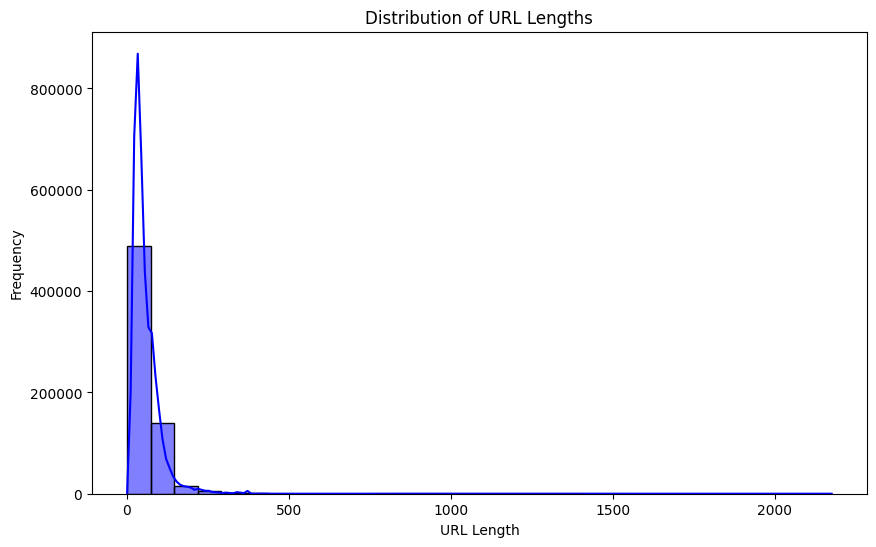

In [31]:
# Plot the distribution of URL lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='url_len', bins=30, kde=True, color='blue')
plt.title('Distribution of URL Lengths')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

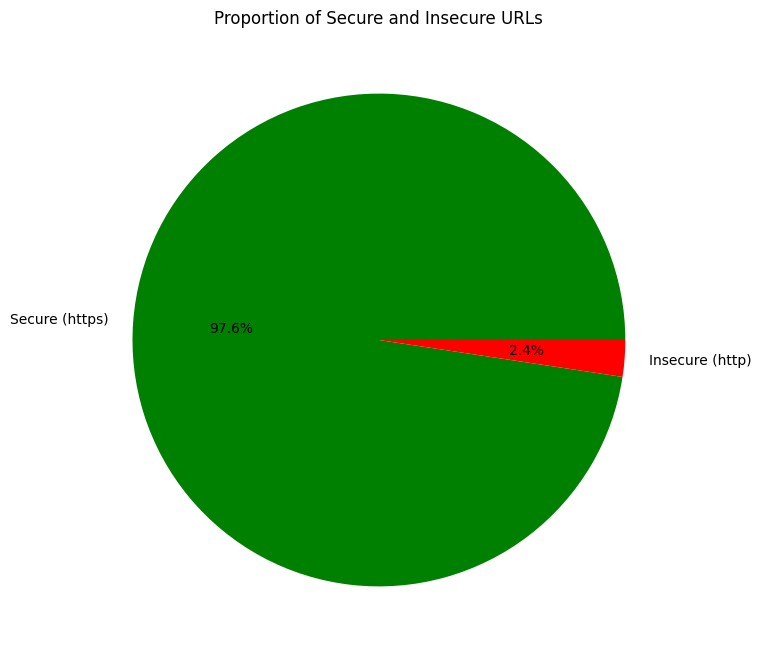

In [32]:
secure_counts = data['secure_http'].value_counts()

# Pie chart
plt.figure(figsize=(8, 8))
secure_counts.plot.pie(autopct='%1.1f%%', labels=['Secure (https)', 'Insecure (http)'], colors=['green', 'red'])
plt.title('Proportion of Secure and Insecure URLs')
plt.ylabel('')
plt.show()

<ipython-input-33-e085ee4b017a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='abnormal_url', y='url_len', palette='Set2')


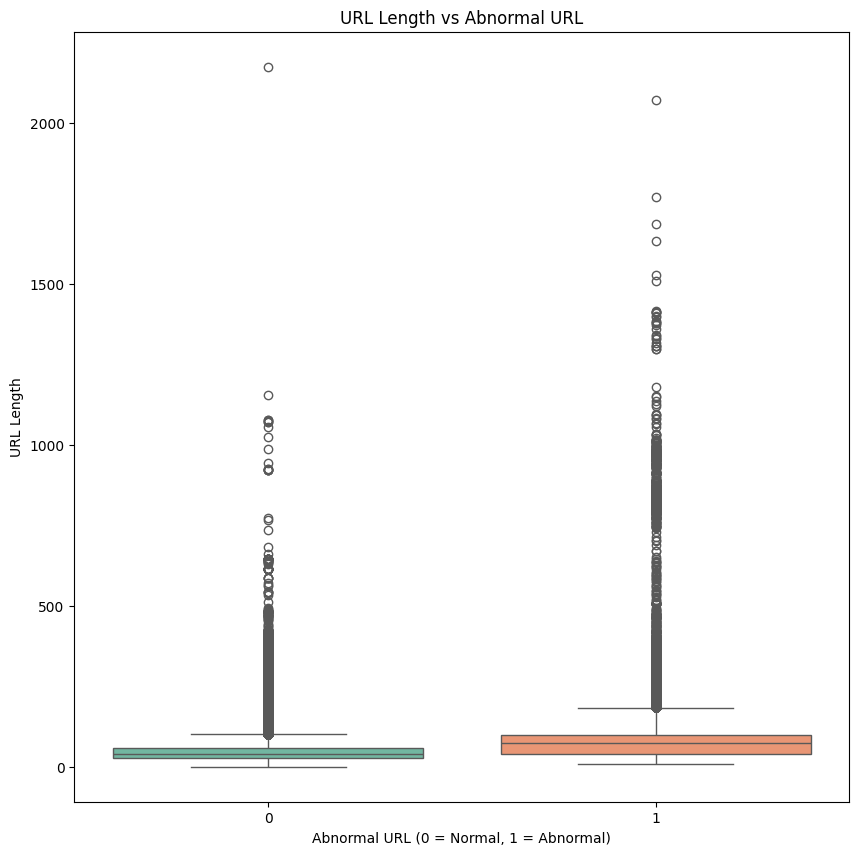

In [33]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=data, x='abnormal_url', y='url_len', palette='Set2')
plt.title('URL Length vs Abnormal URL')
plt.xlabel('Abnormal URL (0 = Normal, 1 = Abnormal)')
plt.ylabel('URL Length')
plt.show()

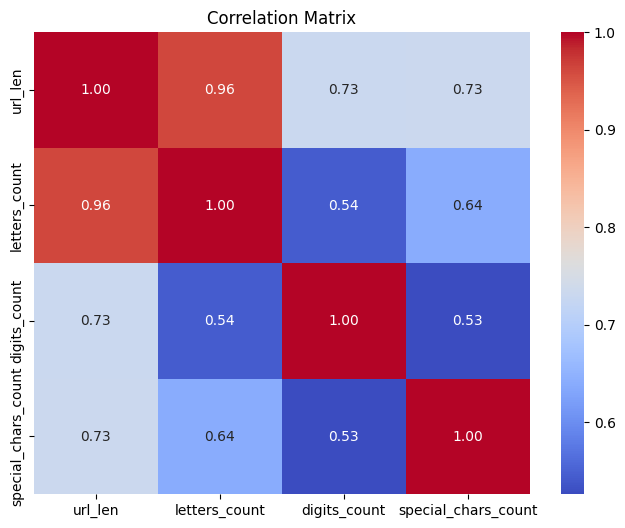

In [34]:
# Compute correlation matrix
correlation_matrix = data[['url_len', 'letters_count', 'digits_count', 'special_chars_count']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<ipython-input-35-fa5fe2d7f94c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', palette='viridis')


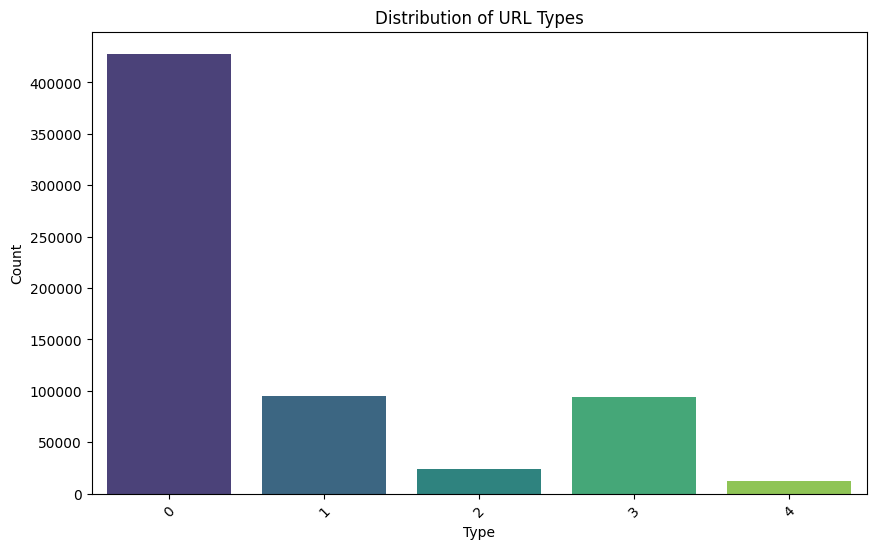

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', palette='viridis')
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Classification Models**

In [36]:
X_combined = pd.concat([pd.DataFrame(X_tfidf.toarray()), data[['url_len', 'letters_count', 'digits_count',
       'special_chars_count', 'shortened', 'abnormal_url', 'secure_http']]], axis=1)

In [37]:
X_combined

,0,1,2,3,4,5,6,7,8,9,...,997,998,999,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,76,49,18,16,0,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,76,43,23,17,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,76,44,22,17,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,76,46,18,19,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,76,48,18,17,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,39,21,12,6,0,0,0
653042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44,29,7,8,0,0,0
653043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,38,33,3,6,0,0,0
653044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45,36,0,9,0,0,0


In [38]:
y_balanced

,type
0,0
1,0
2,0
3,0
4,0
...,...
59600,4
59601,4
59602,4
59603,4


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, data['type'], test_size=0.2, random_state=42)

In [42]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [43]:
print(f"XGBoost Performance:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
[[85165    14     5   705     3]
 [  125 18672     4   125     3]
 [  117   107  4173   258     1]
 [ 3487   640    54 14625    16]
 [    0     1     0     0  2310]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     85892
           1       0.96      0.99      0.97     18929
           2       0.99      0.90      0.94      4656
           3       0.93      0.78      0.85     18822
           4       0.99      1.00      0.99      2311

    accuracy                           0.96    130610
   macro avg       0.96      0.93      0.95    130610
weighted avg       0.96      0.96      0.96    130610



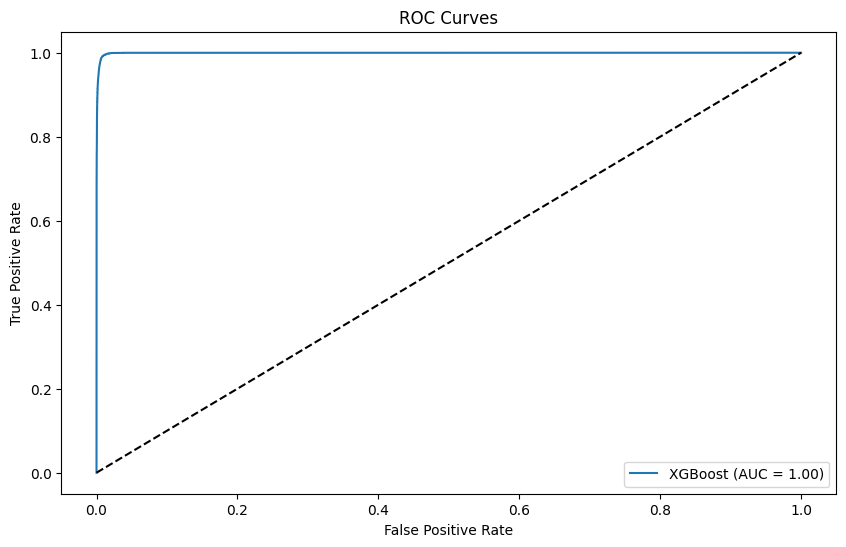

In [44]:
plt.figure(figsize=(10, 6))
for model_name, model in zip(['XGBoost'], [xgb_model]):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [45]:
max_features = 1007
embedding_dim = 128
max_len = X_tfidf.shape[1]

In [46]:
max_len

1000

In [48]:
lstm_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=1007),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(len(data['type'].unique()), activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/2
13061/13061 ━━━━━━━━━━━━━━━━━━━━ 804s 61ms/step - accuracy: 0.8222 - loss: 0.5010 - val_accuracy: 0.8840 - val_loss: 0.3545
Epoch 2/2
13061/13061 ━━━━━━━━━━━━━━━━━━━━ 801s 61ms/step - accuracy: 0.8846 - loss: 0.3487 - val_accuracy: 0.8885 - val_loss: 0.3348


In [52]:
print(f"LSTM model Performance:")
# Convert predictions to discrete class labels using argmax
y_pred_lstm = np.argmax(lstm_model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))

LSTM model Performance:
4082/4082 ━━━━━━━━━━━━━━━━━━━━ 98s 24ms/step
[[83772   745     9  1268    98]
 [ 1892 16496    81   317   143]
 [  298   333  3682   318    25]
 [ 6170  1685   272 10578   117]
 [  316   272    23    64  1636]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     85892
           1       0.84      0.87      0.86     18929
           2       0.91      0.79      0.84      4656
           3       0.84      0.56      0.67     18822
           4       0.81      0.71      0.76      2311

    accuracy                           0.89    130610
   macro avg       0.86      0.78      0.81    130610
weighted avg       0.89      0.89      0.88    130610



In [56]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_bert = bert_tokenizer(list(X), padding=True, truncation=True, return_tensors="tf")
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(data['type'].unique()))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
bert_model.compile(optimizer='adam', # Changed to string identifier 'adam'
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
bert_model.fit(dict(X_bert), y, epochs=1, batch_size=32, validation_split=0.2)


  400/16327 [..............................] - ETA: 1:52:18 - loss: 0.8516 - accuracy: 0.7291

KeyboardInterrupt: 

In [ ]:
bert_results = bert_model.evaluate(dict(X_bert), y)
print(f"\nBERT Performance:\nAccuracy: {bert_results[1]}\nLoss: {bert_results[0]}")

  207/20408 [..............................] - ETA: 50:55 - loss: 0.3403 - accuracy: 1.0000